# stochastic analysis of COVID19 time series in "Baden-Württemberg"
data as of 10.06.2020 by https://sozialministerium.baden-wuerttemberg.de/de/gesundheit-pflege/gesundheitsschutz/infektionsschutz-hygiene/informationen-zu-coronavirus/lage-in-baden-wuerttemberg/

algorithm from "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec [1]

In [1]:
import pandas as pd
import numpy as np
from scipy import signal, stats, special
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
import datetime

## 1. extract values from selected list
variables names: *I: Infected; *T: Deceased

In [194]:
filename = 'Tabelle_Coronavirus-Faelle-BW.xlsx'
dfi = pd.read_excel(filename, sheet_name='Infizierte Coronavirus in BW', header=None)
dft = pd.read_excel(filename, sheet_name='Todesfälle Coronavirus in BW', header=None)

In [195]:
ctyI = np.nan_to_num(np.asarray(dfi))
ctyT = np.nan_to_num(np.asarray(dft))
# row 7: dates
# row 8 to 51: regions
    # row 18: Freiburg
    # row 38: Ravensburg
# row 52: sum

### 1.1 plot regional data

In [240]:
index = 17
region = ctyI[index][0]
title = 'Corona cases in %s' % region

# calculate x data: dates
# currently: approximation where each month is approximated by 30 days.
xI = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyI[6]]
xT = [el.day+el.month*30 if type(el) == datetime.datetime else False for el in ctyT[6]]

# calculate trajectory points from data of given index
yI = [el if type(el) == int else False for el in ctyI[index]]
yT = [el if type(el) == int else False for el in ctyT[index]]

# remove first element of lists (column of regions, only str in these)
del xI[0]
del xT[0]
del yI[0]
del yT[0]

# flip arrays
xI = np.flip(xI)
xT = np.flip(xT)
yI = np.flip(yI)
yT = np.flip(yT)

# Calculate new cases per day
dyIdt = np.diff(yI, prepend=0)
    
# Calculate new deaths per day
dyTdt = np.diff(yT,prepend=0)

# Checking for mistakes
print('I1:', len(xI) == len(yI))
print('T1:', len(xT) == len(yT))
print('dIdt:', len(xI) == len(dyIdt))
print('dTdt:', len(xT) == len(dyTdt))
checksum = 0
for el in dyIdt:
    checksum += el
print("checksum I:", checksum == yI[-1])
checksum = 0
for el in dyTdt:
    checksum += el
print("checksum T:", checksum == yT[-1])

I1: True
T1: True
dIdt: True
dTdt: True
checksum I: True
checksum T: True


<IPython.core.display.Javascript object>


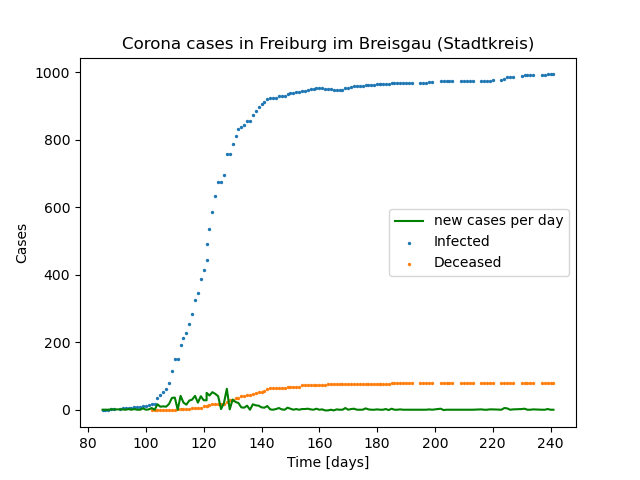

In [245]:
# Plot infected, deceased and new cases per day
%matplotlib notebook
plt.scatter(xI, yI, label='Infected', s=2)
plt.scatter(xT, yT, label='Deceased', s=2)
plt.plot(xI, dyIdt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title(title)
plt.legend()
plt.show()
#plt.savefig('%sCases.png' % region)

### 1.2 plot total data

In [229]:
# calculation of x-data in cell above

# calculate total sum
yI_total = [el for el in ctyI[51]]
yT_total = [el for el in ctyT[51]]

# remove first element of lists (column of regions, only str in these)
del yI_total[0]
del yT_total[0]

# flip arrays
yI_total = np.flip(yI_total)
yT_total = np.flip(yT_total)

# Calculate new cases per day
dyI_totaldt = np.diff(yI_total, prepend=0)
    
# Calculate new deaths per day
dyT_totaldt = np.diff(yT_total, prepend=0)
    
# Checking for mistakes
print('I2:', len(xI) == len(yI_total))
print('T2:', len(xT) == len(yT_total))
print('dI_totaldt:', len(xI) == len(dyI_totaldt))
print('dT_totaldt:', len(xT) == len(dyT_totaldt))
checksum = 0
for el in dyI_totaldt:
    checksum += el
print("checksum I:", checksum == yI_total[-1])
checksum = 0
for el in dyT_totaldt:
    checksum += el
print("checksum T:", checksum == yT_total[-1])

I2: True
T2: True
dI_totaldt: True
dT_totaldt: True
checksum I: True
checksum T: True


<IPython.core.display.Javascript object>


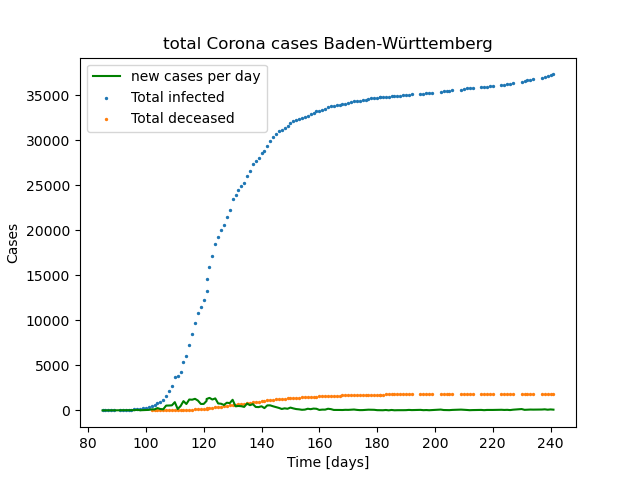

In [228]:
# Plot infected, deceased and new cases per day
%matplotlib notebook
plt.scatter(xI, yI_total, label='Total infected', s=2)
plt.scatter(xT, yT_total, label='Total deceased', s=2)
plt.plot(xI, dyI_totaldt, label='new cases per day', c='g')
plt.xlabel('Time [days]')
plt.ylabel('Cases')
plt.title('total Corona cases Baden-Württemberg')
plt.legend()
plt.show()
#plt.savefig('BWCases.png')

## 2. perquisites for stochastic analysis

### 2.1 noised HO data
We will use the harmonic oscillator (HO) as example data. In the following, noised data will be created. Using the commonly known analytical solution of HO:

$$
\dot{x} = v\\
\dot{v} = -x + \Gamma(t) - \gamma v
$$

In [519]:
epsilon = 10e-3
tau = 100000
r = np.linspace(0, 100*np.pi, num=tau)
x = [1 * np.sin(t) + np.random.randn() * epsilon for t in r]
v = [1 * np.cos(t) + np.random.randn() * epsilon for t in r]

<IPython.core.display.Javascript object>


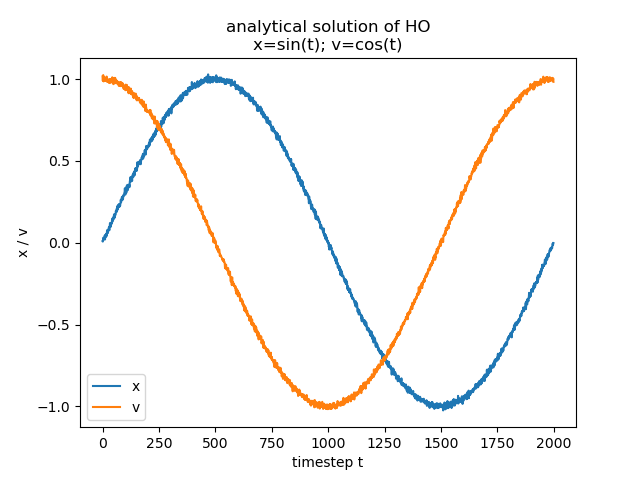

In [520]:
%matplotlib notebook
plt.clf()
plt.plot(x[:2000], label='x')
plt.plot(v[:2000], label='v')
#plt.scatter(v[:2000], x[:2000], label='phase', s=0.25)

plt.xlabel('timestep t')
plt.ylabel('x / v')
plt.title('analytical solution of HO\nx=sin(t); v=cos(t)')
plt.legend()
plt.show()

### 2.2 evaluating $p(x,t|x',t')$
First we calculate the histogram of our HO example to get a brief overview of what we want.

Secondly we will define a function which calculates the probability of the time series having the value x at time t.

$p(x,t|x',t')$ is defined as the following:

$$
% not sure about that one
P_{l|k} = (y_{k+1}, t_{k+1}; ...; y_{k+l}, t_{k+l} | y_{1}, t_{1}; ...; y_{k}, t_{k}) = \frac{P_{k+l}(y_{1}, t_{1}; ...; y_{k+l}, t_{k+l})}{P_{k}(y_{1}, t_{1}; ...; y_{k}, t_{k})}
$$

where

$$
P_{n}(y_{1}, t_{1}; ...; y_{n}, t_{n}) = \int_{}^{} \delta (y_1 - Y_X(t_1)) \cdot \cdot \cdot \delta (y_n - Y_X(t_n)) P_X(x) dx
$$

therefore

$$
P_1(y, t) = \int_{}^{} \delta (y - Y_X(t))P_X(x) dx
$$

#### 2.2.1 showing example histogram of HO

<IPython.core.display.Javascript object>


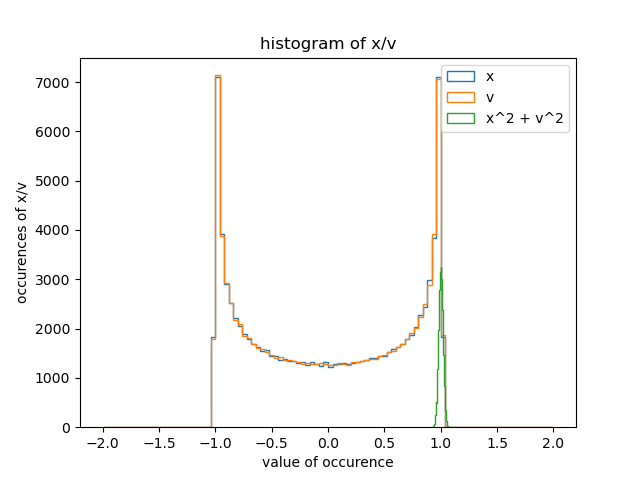

In [362]:
%matplotlib notebook
plt.clf()

plt.hist(x, bins=100, range=(-2, 2), histtype='step', label='x')
plt.hist(v, bins=100, range=(-2, 2), histtype='step', label='v')

t_series = [x[i]**2 + v[i]**2 for i in range(len(x))]
plt.hist(t_series, bins=100, histtype='step', label='x^2 + v^2')

plt.title('histogram of x/v')
plt.xlabel('value of occurence')
plt.ylabel('occurences of x/v')
plt.legend()
plt.show()

#### 2.2.2 declaring functions

In [523]:
'''Integer integration

Helper fuction to make discrete integration of time series x (array like) from a to b easier.
'''
integer_integration = lambda x, a, b: np.sum(x[a:b])

'''Integer derivate

Helper function to derivate a time series x (array like).
Returns a array[len(x)-1].

also represented by np.diff(x). But my own shit.
'''
integer_derivate = lambda x: [x[i+1] - x[i] for i in range(len(x)-1)]

def probability_hist(s, bins=100):
    '''histogram
    
    Returns a histogram as array of array for a given time series s.
    
    Parameters:
        - (array like) s: time series
        - (int or sequence of scalars or str, optional) bins: f bins is an int,
            it defines the number of equal-width bins in the given range 
        
    Returns:
        - (list) x, (list) y
            Where (list of int) x represents the x-value of occurence and (list of int) y
            the probability of occurence: y[n] in [0, 1] for all n, where n = len(s)
    '''
    n = len(s)
    y, x = np.histogram(s, bins=bins)
    
    y_ = [el / n for el in y]
    
    return x, y_

def p(s: list, x: float, t: int, bins: int=100, use_t: bool=True, hist=None) -> float:
    '''proability function
    
    Returns the probability for a time series s having at time t the value x.
    
    Parameters:
        - (array like) s: time series
        - (float) x: value the series shouls have
        - (int) t: time at which to evaluate
        - (int) bins:
        - (bool) use_t:
        - (probability_hist()) hist: if None hist will be evaluated newly
    '''
    if (s[t] != x) and use_t:
        # if the series s has at time t not the expected value of x
        # the probability is zero. We will return zero here.
        return 0
    
    # histogram will be calculated newly if its not given in args.
    if hist is None:
        hist = probability_hist(s, bins=bins)
    
    # checking if x is in interval
    # hist[0]: x values
    # hist[1]: probability
    min = np.min(hist[0])
    max = np.max(hist[0])
    if x < min or x > max:
        # if x is out of interval the probability is zero
        #print('[!] Warning: x (%f) is out of range at min %f, max %f' % (x, min, max))
        return 0
    
    # find nearest value of x in x-values hist[0]
    idx = (np.abs(hist[0][:-1] - x)).argmin()
    
    return hist[1][idx]

def p_cond(s: list, x: float, t: int, x_: float, t_: float, bins: int=100, use_t: bool=True, hist=None) -> float:
    '''conditional probability function
    as used in [1](6a): p(y, t + tau | x, t)
    inherited from [2](9.58)
    
    returns the probability of s having the value x at time t, where at time t_ value x_ was present.
    '''
    p_1 = p(s, x, t, bins=bins, use_t=use_t, hist=hist)
    p_2 = p(s, x_, t_, bins=bins, use_t=use_t, hist=hist)
    
    if (p_2 != 0):
        result = p_1 / p_2
    else:
        result = 0
    
    return result

#### 2.2.3 density examples

<IPython.core.display.Javascript object>


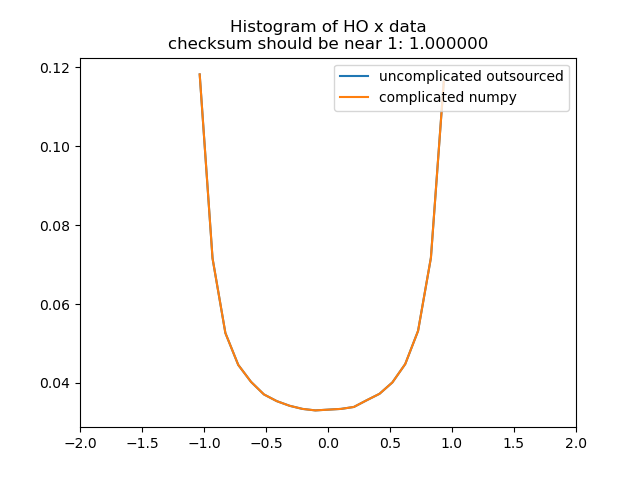

In [522]:
# probability_hist()
# test on HO Data
%matplotlib notebook

n = len(x)

hist = probability_hist(x, bins=20)
checksum = np.sum(hist[1])

plt.clf()
plt.plot(hist[0][:-1], hist[1], label='uncomplicated outsourced')
plt.plot([el for el in np.histogram(x, bins=20)[1]][:-1],\
         [(1 / len(x)) * el for el in np.histogram(x, bins=20)[0]], label='complicated numpy')
plt.xlim((-2, 2))
plt.title('Histogram of HO x data\nchecksum should be near 1: %f' % checksum)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


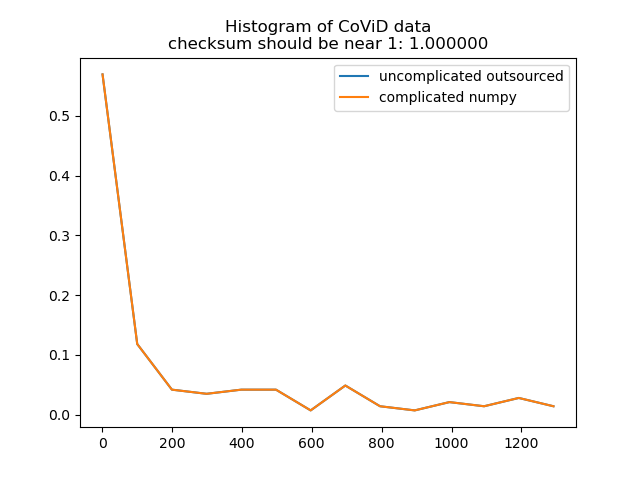

In [515]:
# probability_hist()
# test on COVID Data
%matplotlib notebook

n = len(dyI_totaldt)

hist = probability_hist(dyI_totaldt, bins=n//10)
checksum = np.sum(hist[1])

plt.clf()
plt.plot(hist[0][:-1], hist[1], label='uncomplicated outsourced')
plt.plot([el for el in np.histogram(dyI_totaldt, bins=n//10)[1]][:-1],\
         [(1 / len(dyI_totaldt)) * el for el in np.histogram(dyI_totaldt, bins=n//10)[0]], label='complicated numpy')
plt.title('Histogram of CoViD data\nchecksum should be near 1: %f' % checksum)
plt.legend()
plt.show()

### 2.3 now for the diffusion coefficients
Those are defined in [1] as the following:

$$
D^{(1)}_i(x) = T^{(1)}_i(x, \tau)
\\
D^{(2)}_{ij} = T^{(2)}_{ij}(x, \tau) - \tau T^{(1)}_i(x, \tau) T^{(1)}_j(x, \tau)
$$

Where

$$
T^{(1)}_i(x, \tau) = \frac{1}{\tau} \int_{- \infty}^{\infty} (y_i - x_i) p(y, t + \tau | x, t) \prod_{k}^{} dy_k
\\
T^{(2)}_{ij}(x, \tau) = \frac{1}{\tau} \int_{- \infty}^{\infty} (y_i - x_i) (y_j - x_j) p(y, t + \tau | x, t) \prod_{k}^{} dy_k
$$

For a stationary process $p(y, t + \tau | x, t)$ is - and therefore $T^{(i)}$ and $D^{(i)}$ too - independent of time. Whatever a stationary process means. Eh, idk...

In [460]:
def T_1(s, x, tau, hist=None, a=-np.inf, b=np.inf):
    '''calculate conditional moment of grade 1
    as inherited from [1](6a)
    
    These will be determined trough numerical integration.
    
    Parameters:
        - (array like) s: time series
        - (float) x: point of evaluation
        - (probability_hist()) hist: histogram if precalculated
        - (float) a: lower integration border.
        - (float) b: upper integration border.
    '''
    t = 0 # t is unused here!
    
    integrand = lambda y: (y - x) * p_cond(s, y, t + tau, x, t, bins=100, use_t=False, hist=hist)
    integratum, error = quad(integrand, a, b)
    
    #print('integrated yields:', integratum, 'with absolute error:', error)
    
    return (1 / tau) * integratum

#### 2.3.1 Testing function on HO Data

In [ ]:
# 1. retrieve diffusion coefficient
# tau cannot be smaller than one, due to integer integration.
# timesteps must be defined in linspace of original time series

# 1.a T_1 on x
hist = probability_hist(x)
tau = 1
x_output = []
ar = np.linspace(-1, 1, 250)

for i in ar:
    #print('starting calculation of conditional moment at x =', i)
    x_output.append((i, T_1(x, i, tau, hist=hist, a=-1.5, b=1.5)))
print('done at iteration', i)

<ipython-input-460-936fcf9bfde8>:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integratum, error = quad(integrand, a, b)


<IPython.core.display.Javascript object>


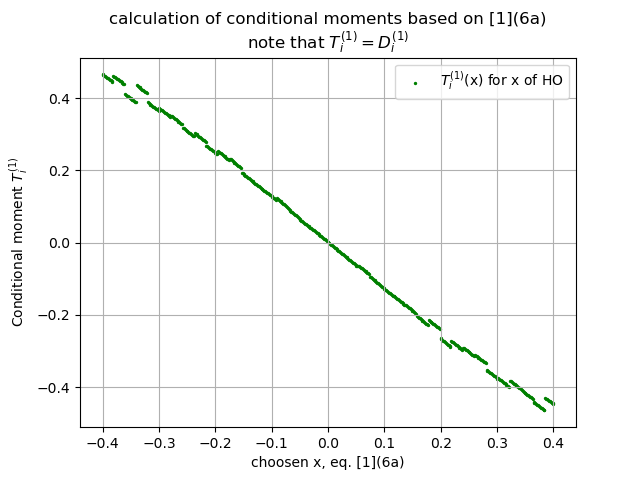

In [529]:
# 2. plotting
%matplotlib notebook

# 2.a x
ax = [el[0] for el in x_output]
ay = [el[1] for el in x_output]
plt.scatter(ax, ay, s=2, c='g', label='$T^{(1)}_i$(x) for x of HO')

plt.legend()
plt.xlabel('choosen x, eq. [1](6a)')
plt.ylabel('Conditional moment $T^{(1)}_i$')
plt.title('calculation of conditional moments based on [1](6a)\nnote that $T^{(1)}_i = D^{(1)}_i$')
plt.grid()
plt.show()

#### 2.3.2 Testing functions on Langevin

$\dot{X}(t) = \varepsilon X(t) - X^3(t) + g \Gamma (t)$ where $\varepsilon = 0.1$ and $g = 0.05$

<IPython.core.display.Javascript object>


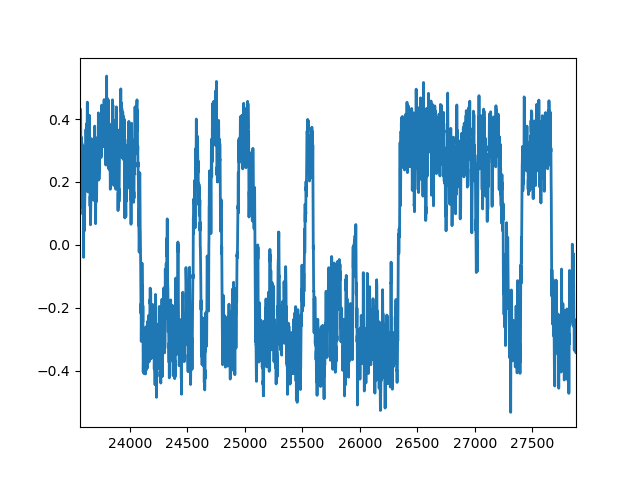

In [487]:
# example of https://ipython-books.github.io/134-simulating-a-stochastic-differential-equation/
epsilon = 0.1
g = 0.05

dt = 1  # Time step.
T = 100000  # Total time.
n = int(T / dt)  # Number of time steps.
t = np.linspace(0, T, n)  # Vector of times.

sqrtdt = np.sqrt(dt)

x = np.zeros(n)

for i in range(n - 1):
    x[i + 1] = x[i] + dt * (epsilon * x[i] - x[i] ** 3) + \
        np.random.randn() * g * sqrtdt

%matplotlib notebook
fig, ax = plt.subplots(1, 1)
ax.plot(t, x, lw=2)
plt.show()

In [526]:
# Testing T_1 on Langevin

# 1. retrieve diffusion coefficient
# tau cannot be smaller than one, due to integer integration.
# timesteps must be defined in linspace of original time series

# 1.a T_1 on x
hist = probability_hist(x)
tau = 1
x_output = []
ar = np.linspace(-0.4, 0.4, 500)

for i in ar:
    x_output.append((i, T_1(x, i, tau, hist=hist, a=-0.6, b=0.6)))
print('done at iteration', i)

<ipython-input-460-936fcf9bfde8>:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integratum, error = quad(integrand, a, b)
<ipython-input-460-936fcf9bfde8>:17: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integratum, error = quad(integrand, a, b)


done at iteration 0.4


<IPython.core.display.Javascript object>


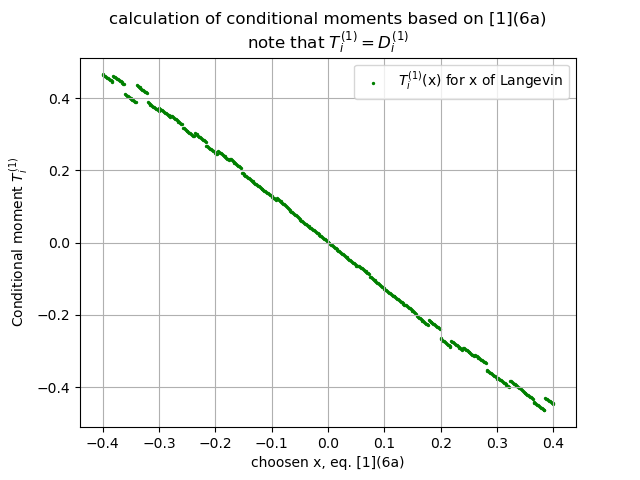

In [530]:
# 2. plotting
%matplotlib notebook

# 2.a x
ax = [el[0] for el in x_output]
ay = [el[1] for el in x_output]
plt.scatter(ax, ay, s=2, c='g', label='$T^{(1)}_i$(x) for x of Langevin')

plt.legend()
plt.xlabel('choosen x, eq. [1](6a)')
plt.ylabel('Conditional moment $T^{(1)}_i$')
plt.title('calculation of conditional moments based on [1](6a)\nnote that $T^{(1)}_i = D^{(1)}_i$')
plt.grid()
plt.show()

## literature

[1] "Analysis of time series from stochastic processes" by J.Gradisek, S.Riegert, R.Freidrich, I.Grabec

[2] "Simulation - Advanced Topics" by A.Greiner as of June 11, 2020

[3] "The Fokker-Planck Equation" by H.Risken as of 1996